
### Selection and Backtesting of a Portfolio of Pairs Based on Cointegration in Python
Author: Piotr Arendarski, Ph.D, Anglia Ruskin University
*****
#### A brief outline of what this script does:
1. Select universe of stocks (index), get tickers and download historical data
2. Select pairs based on Engle-Granger cointegration test
3. Backtest portfolio of pairs using zscore method
4. Check current zScore of cointegrated pairs
5. Parameters optimisation

The traditional idea of a mean reverting "pairs trade" is to simultaneously long and short two separate assets sharing underlying factors that affect their movements. An example from the equities world might be to long Coca Cola (NYSE:KO) and short PEPSI (NYSE:PEP).

In the previous script [https://github.com/arendarski/Simple-Mean-Reversion-Strategy-in-Python] we presented a simple algorithm in which a user inputs a trading pair, the script performs a set of unit root tests for mean reversion and subsequently backtest the selected pair.

In this post, I am going to complicate things a little bit. Let us build an algorithm that will accept a list of stocks and then select pairs that are likely to exhibit mean reversion properties. Finally, the script will perform backtest.

We start as usual from importing relevant modules.

In [36]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import itertools
from datetime import datetime, timedelta, date
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from arch.unitroot import engle_granger
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
from bs4 import BeautifulSoup
import requests, requests_html
warnings.simplefilter('ignore')

### Part 1: Selecting universe, getting tickers and downloading historical data

Then we need to select a universe of stocks we want to test. Here below I created a simple script which downloads tickers of selected index available at stooq.com.

We selected Dow Jones Industrial Average as our universe of stocks.

The function to get tickers works only for stooq.com website. Please check what is the symbol of your desired index and check if the index has constituents. Then it is important to select either yahoo or stooq as the source for downloading historical data. This will determine the format of tickers. The stooq's tickers have the format of 'XX.US' for US stocks, but for German stocks it is XX.DE, yahoo's tickers have the format of 'XX' for US stocks.

Please take a note that stooq.com and yahoo.finance.com has a limit of requests, so you may see an error due to too many requests if you select index with more than 100 constituents.

Finally, the next step is to download historical data for the tickers we selected. You may use it either yahoo or stooq. 
For more exotic stocks (e.g. Czech Republic or Poland), please check what is the symbol. The script may not work for some exotic symbols if you use yahoo.  have not tested all possible indices.

In [50]:
# SELECTS PERIOD, INDEX and HISTORICAL DATA SOURCE 
index = '^dji' # or e.g. ^spx, ^dax, ^ndx
data_source = 'stooq' # select: 'yahoo' or'stooq'
start_date = '2017/01/01'
end_date = date.today() # Please do not change this, otherwise current Z-score are calculated incorrectly

# GETTING TICKERS from stooq.com
def getTickers(index = index, data_source = data_source):
# info about the function: https://github.com/parendarski/getTickers        
    tickers = []
    url = f'https://stooq.pl/q/i/?s={index}&i'
    print(f'Getting tickers from page number: 1')
    data = pd.read_html(url) 
    # clean_table(data)
    data = data[0].iloc[1:]
    new_header = data.iloc[0] #grab the first row for the header
    data = data[3:] #take the data less the header row
    data.columns = new_header #set the header row as the df header

    # iterates through the column with tickers at the FIRST PAGE
    for ticker in data.iloc[:,0]:
        if data_source == 'yahoo':
            if str('nan') not in str(ticker):
                tickers.append(ticker.split('.')[0])
        else:
            if str('nan') not in str(ticker):
                tickers.append(ticker) 
    print(f'Tickers collected so far: {len(tickers)}')
    print('---')
    
    # iterates through the column with tickers for the NEXT PAGES, break the loop when the last page with tickers is found 
    for page in range(2, 100, 1):        
        url = f'https://stooq.pl/q/i/?s={index}&l={page}&i'
        print(f'Getting tickers from page number: {page}')
        data = pd.read_html(url)
        data = data[0].iloc[1:]
        new_header = data.iloc[0] 
        data = data[3:] 
        data.columns = new_header
        for ticker in data.iloc[:,0]:
            if data_source == 'yahoo':
                tickers_len = len(tickers)
                if str('nan') not in str(ticker):
                    tickers.append(ticker.split('.')[0])
            else:
                if str('nan') not in str(ticker):
                    tickers.append(ticker)
        print(f'Tickers collected so far: {len(tickers)}')
        print('---')
        if len(data.iloc[:,0]) == 2:
            break
    print(f'Total tickers collected: {len(tickers)}')  
    print(f'Tickers collected: {tickers}')
    return tickers    

symbList = getTickers(index = index, data_source = data_source)

# DOWNLOADS HISTORICAL DATA from yahoo or stooq.com into DATAFRAME 
if data_source == 'yahoo': #downloads data from yahoo
    # Na's are not dropped, this means that some stocks may have nan's and they will not be used for the further analysis
    try:
        df = pdr.get_data_yahoo(symbList, start = start_date, end = end_date)['Adj Close']#.dropna()
    except:
        print(f'Can not get data ...')
else:
    start_date = start_date.split('/')
    start_date = ''.join(start_date) 
    end_date = str(end_date)
    end_date = end_date.split('-')
    end_date = ''.join(end_date) 

    def getStooqData(symbol, start, end, freq):
        url = f'https://stooq.com/q/d/l/?s={symbol}&d1={start}&d2={end}&i={freq}'
        df = pd.read_csv(url, index_col='Date')
        return df
    print('...')
    symb_prices = []
    for symbol in symbList:
        print(f'{symbol}, {start_date}, {end_date}')
        data = getStooqData(symbol, start_date, end_date, 'd')['Close']
        
        print(f'Getting data for {symbol}')
        data.name = symbol
        symb_prices.append(data)

    df = pd.concat(symb_prices, axis = 1)  
    df.fillna(method='ffill', inplace=True)

Now need to split the sample into training and testing. The training sample will be used to select pair of assets sharing underlying factors that affect their movements. The testing sample will be used to backtest the portfolio consists of all the selected pairs.

In [38]:
# SPLITS DATA INTO TRANING and TESTING SAMPLE
split_train = 0.5  
train_sample = int(split_train * len(df))

### Part 2: Selecting pairs based on Engle-Granger cointegration test

In [49]:
# creates combinations of all tickers within the selected index
symbol_pairs = list(itertools.combinations(symbList, 2))
significance_level = 0.05
coint_pairs = []

# selects pairs based on Engle-Granger cointegration test 
def find_cointegrated_pairs(dataframe):
    for y, x in symbol_pairs:
            try:
                eg_test = engle_granger(dataframe[y], dataframe[x], trend="n")
                print(f'{y} - {x} : p-value = {eg_test.pvalue}')
                if eg_test.pvalue < significance_level:
                    coint_pairs.append((y, x, eg_test.pvalue))
            except:
                print(f'Oops! Nans detected. The pair: {x} - {y} will be skipped.')
    return coint_pairs

find_cointegrated_pairs(df[0:train_sample])

In [40]:
# displays the selected pairs
print(f'All the selected pairs with p-value lower or equal: {significance_level} are: ')
for c, pair in enumerate(coint_pairs, 1):
    print(f'Pair : {pair[0]} - {pair[1]}, pvalue: {pair[2]}')

All the selected pairs with p-value lower or equal: 0.05 are: 
Pair : AAPL.US - HD.US, pvalue: 0.03603298641676234
Pair : AAPL.US - NKE.US, pvalue: 0.04185354348661106
Pair : AAPL.US - PFE.US, pvalue: 0.02566922437694023
Pair : AAPL.US - VZ.US, pvalue: 0.040223030996817816
Pair : AXP.US - VZ.US, pvalue: 0.02197424644088992
Pair : CVX.US - MCD.US, pvalue: 0.03204509389482579
Pair : DIS.US - XOM.US, pvalue: 0.027057252798681344
Pair : HD.US - VZ.US, pvalue: 0.047116385147751356
Pair : JNJ.US - KO.US, pvalue: 0.01820634294340254
Pair : JNJ.US - XOM.US, pvalue: 0.013712611276524862
Pair : KO.US - XOM.US, pvalue: 0.006773370251353295
Pair : MCD.US - VZ.US, pvalue: 0.03801749611930025
Pair : MCD.US - XOM.US, pvalue: 0.011393020411013774
Pair : MSFT.US - UNH.US, pvalue: 0.033215881015626995
Pair : PFE.US - VZ.US, pvalue: 0.03295500242903921
Pair : RTX.US - VZ.US, pvalue: 0.013140517448162694
Pair : UNH.US - V.US, pvalue: 3.628897574496797e-05
Pair : VZ.US - WMT.US, pvalue: 0.04819723310819516

This helper script here below selects top x cointegrated pairs under assumption that you like to select large universe (e.g. S&P500) and restrict number of pairs based on p-value. If you like to use it, please take a note that the list of top pairs is stored in 'top_coint_pairs_list' object. This is different list that is used throughout the rest of the script.

In [41]:
# # HELPER SCRIPT: selects only top x cointegrated pairs if you want to restrict number of pairs

# pvalue_list_sorted = coint_pairs
# pvalue_list_sorted = sorted(top_coint_pairs, key=lambda x: abs(x[2]),reverse = False) 
# top_pairs = 50
# top_coint_pairs_list = []

# for c, pair in enumerate(pvalue_list_sorted, 1):
#     if len(top_coint_pairs_list) < top_pairs:
#         top_coint_pairs_list.append((pair[0], pair[1], pair[2]))
#         print(f'{c}: |{pair[0]: <4}| - |{pair[1]: <4}| p-value: {round(pair[2],3)}')
#     else:
#         break

### Part 3: Bactesting portfolio of pairs

Now it is time to take all the pairs of cointegrated assets and check we could make some money during the testing period.

We will utilise very popular mean reversion strategy that assumes we simply buy low and sell high based on the ratio called zScore. There are two alternatives of this strategy. Please check our previous post [LINK] for more details.

In [42]:
def backtest(df, sym1, sym2, strategy, roll_beta_window, zscore_window, entryZscore, exitZscore ):
    
#     """BACKTESTING SELECTED PAIR.....

#     Parameters
#     ----------
#     dataframe : pandas dataframe
#         All assets close prices
#     sym1 : string
#         The symbol of asset one
#     sym2 : string
#         The symbol of asset two
#     strategy : int
#         Trading strategy selection {1,2}.
#     roll_beta_window : integer 
#     zscore_window : integer
#     entryZscore : float
#     exitZscore : float

#     Returns
#     -------
#     dataframe[f'Cum_rets: {sym1} {sym2}'], CAGR, sharpe, num_days_in_market : pd.series
#         Time series of cumulative returns for selected pair
#     comp_ann_return_net, annualised_sharpe_net , num_days_in_the_market : float
#         Compound annual growth rate (CAGR) for selected pair
#    annualised_sharpe_net , num_days_in_the_market : float
#         Sharpe Ratio for selected pair
#    num_days_in_the_market : integer
#         Number of days the pair is 'in the market'
#     """
    y = df[sym1]
    x = df[sym2]

    # finds intersection between two series and make sure DataFrames are the same length
    intersect = y.index.intersection(x.index)
    y = y.loc[intersect]
    x = x.loc[intersect]

    # creates a dataframe using Adj. Close prices from both series
    dataframe = pd.DataFrame(index=y.index).dropna()
    
    dataframe['%s_close' % sym1.lower()] = y
    dataframe['%s_close' % sym2.lower()] = x   
    
    # calculates rolling OLS this allows to dynamically adjust weights without lookahead bias
    roll_fit = RollingOLS(y, x, window=roll_beta_window).fit()
    dataframe['hr'] = -roll_fit.params
    dataframe['test_spread'] = y + (x * dataframe.hr)
    
    # calculates Z-scores
    meanSpread = dataframe['test_spread'].rolling(window=int(zscore_window)).mean()
    stdSpread = dataframe['test_spread'].rolling(window=int(zscore_window)).std()
    dataframe['zScore'] = (dataframe['test_spread']- meanSpread) / stdSpread

    # selects a trading model : 1 or 2
    #     :1 (standard model): buy/sell when z-score reach an entry threshold, 
    #        and exit when z-score reaches exit threshold.
    #     :2 (alternative model): buy/sell when z-score reach an entry threshold, 
    #        and the current z-score level is lower/higher that the previous one.

    if strategy == 1:
    # code below (only for model == 1) borrowed from (https://www.pythonforfinance.net/)
        dataframe['long_entry'] = ((dataframe.zScore < - entryZscore) & ( dataframe.zScore.shift(1) > - entryZscore)) 
        dataframe['long_exit'] = ((dataframe.zScore > - exitZscore) & (dataframe.zScore.shift(1) < - exitZscore))  
        dataframe.loc[dataframe['long_entry'],'pos_long'] = 1 
        dataframe.loc[dataframe['long_exit'],'pos_long'] = 0 
        dataframe['pos_long'][0] = 0 
        dataframe['pos_long'] = dataframe['pos_long'].fillna(method='pad') 

        #calculate when portfolio is SHORT
        dataframe['short_entry'] = ((dataframe.zScore > entryZscore) & ( dataframe.zScore.shift(1) < entryZscore))
        dataframe['short_exit'] = ((dataframe.zScore < exitZscore) & (dataframe.zScore.shift(1) > exitZscore))
        dataframe.loc[dataframe['short_entry'],'pos_short'] = -1
        dataframe.loc[dataframe['short_exit'],'pos_short'] = 0
        dataframe['pos_short'][0] = 0
        dataframe['pos_short'] = dataframe['pos_short'].fillna(method='pad')
    
    if strategy == 2:
        dataframe['long_entry'] = ((dataframe.zScore < -entryZscore) & ( dataframe.zScore < dataframe.zScore.shift(1))) 
        dataframe.loc[dataframe['long_entry'],'pos_long'] = 1 
        dataframe['pos_long'] = dataframe['pos_long'].fillna(0) 
        dataframe['long_exit'] = ((dataframe['pos_long'] == 0) & ( dataframe['pos_long'].shift(1) == 1))
        dataframe['short_entry'] = ((dataframe.zScore > entryZscore) & ( dataframe.zScore > dataframe.zScore.shift(1)))
        dataframe.loc[dataframe['short_entry'],'pos_short'] = -1
        dataframe['pos_short'] = dataframe['pos_short'].fillna(0)
        dataframe['short_exit'] = ((dataframe['pos_short'] == 0) & ( dataframe['pos_short'].shift(1) == -1)) 
    
    # combine longs/shorts and remove Look ahead bias by lagging the signal
    dataframe['position'] = dataframe['pos_long'].shift(1) + dataframe['pos_short'].shift(1)

    #########################################
    # Overide entry/exit columns with entry/exit data 
    dataframe['long_entry'] = ((dataframe.pos_long.shift(1) == 1) & ((dataframe.position - dataframe.position.shift(1)) == 1)) * 1
    dataframe['long_exit'] = ((dataframe.long_exit == True) & (dataframe.position == 1)) * 1
    dataframe['short_entry'] = ((dataframe.pos_short.shift(1) == -1)  & ((dataframe.position - dataframe.position.shift(1)) == -1)) * 1
    dataframe['short_exit'] = ((dataframe.short_exit == True) & (dataframe.position == -1)) * 1

    # calculates adjusted spread using using current prices and hedge ratio from previous bar (avoiding look-ahead bias)
    dataframe['test_spread_adj'] = dataframe.iloc[:, 0] + (dataframe['hr'].shift(1) * dataframe.iloc[:, 1])
    
    dataframe['pct_ret'] = ((dataframe['test_spread_adj'] - dataframe['test_spread'].shift(1)) / 
                        (dataframe.iloc[:, 0].shift(1) + (abs(dataframe['hr'].shift(1)) * dataframe.iloc[:, 1].shift(1))))

    # calculates actual return for a day according to your position
    dataframe['port_ret'] = dataframe['position'] * dataframe['pct_ret'] 
    dataframe['port_ret'].fillna(0.0, inplace=True)

    # trading fees (set here as 0.1%:  slippage + transaction fees, for example you pay 1 USD per 1,000 value of trade)
    tr_costs = 0.001
    dataframe['tr_cost_paid'] = (dataframe.long_entry | dataframe.long_exit | dataframe.short_entry | dataframe.short_exit)
    dataframe['port_ret_net'] = dataframe['port_ret'] - ( tr_costs * dataframe['tr_cost_paid'])

    # culmulative porfolio return gross and net
    dataframe['cum_port_ret_net'] = (dataframe['port_ret_net'] + 1.0).cumprod()
    
    # calculates Sharpe Ratio
    try:
        annualised_sharpe_net = np.sqrt(252) * dataframe['port_ret_net'].mean() / dataframe['port_ret_net'].std()
    except ZeroDivisionError:
        annualised_sharpe_net = 0.0
    # calculates CAGR   
    end = dataframe.cum_port_ret_net.iloc[-1]
    start = dataframe.cum_port_ret_net.iloc[0]
    days = len(dataframe.cum_port_ret_net)
    comp_ann_return_net = ((end / start) ** (252/days))  - 1.0  
    
    # calculates number of days the pair is 'in the market'
    num_days_in_the_market = len(dataframe.query("position == 1 or position  == -1")['port_ret'])
    
    # calculate sum of long and short entries
    num_trades_long = dataframe.query('long_entry == True')['long_entry'].sum()
    num_trades_short = dataframe.query('short_entry == True')['short_entry'].sum()
    
    # calculates total trading costs paid
    approx_tr_costs = (num_trades_long + num_trades_short) * tr_costs
    #pd.set_option('display.max_rows', 500)
    
    dataframe[f'Cum_rets: {sym1} {sym2}'] = dataframe['cum_port_ret_net']
    dataframe[f'Zscore: {sym1} {sym2}'] = dataframe['zScore']
    
    return dataframe[f'Cum_rets: {sym1} {sym2}'], comp_ann_return_net, annualised_sharpe_net , num_days_in_the_market

In this section we want to actually execute the backtest function and print the performance metrics for each pair .
Please note, that the performance metrics are presented net of fees. We assume that total trading fees per trade equals 0.1%.

In [43]:
# PERFORMS BACKTEST for the whole portfolio of pairs
all_cum_returns = []
print(f'Bactest for period: {df[train_sample:].index[0]} - {df[train_sample:].index[-1]}')
print(f'Net perfromance statistics (after transaction costs) for total number of pairs: {len(coint_pairs)}' )

for pair in coint_pairs:
    cum_returns, CAGR, sharpe, num_days_in_market = backtest(df[train_sample:], pair[0],pair[1], strategy = 1, 
                                                             roll_beta_window = 20, zscore_window = 20,
                                                             entryZscore = 2.0, exitZscore = 0.5)
    all_cum_returns.append(cum_returns)
    print(f' The pair {pair[0]}-{pair[1]}-> CAGR: {CAGR}, Sharpe: {sharpe}, Number of days in trade: {num_days_in_market}')
    
    # prints equity curve of each pair (for too many pairs the legend does not fit to the image)
#     cum_returns.plot(figsize=(22,14),legend=True)

Bactest for period: 2018-09-19 - 2020-06-05
Net perfromance statistics (after transaction costs) for total number of pairs: 18
 The pair AAPL.US-HD.US-> CAGR: 0.03781852315122691, Sharpe: 0.5146799925559724, Number of days in trade: 123
 The pair AAPL.US-NKE.US-> CAGR: -0.012711650216077897, Sharpe: -0.12145192179952359, Number of days in trade: 146
 The pair AAPL.US-PFE.US-> CAGR: -0.012166525936164962, Sharpe: -0.09715403632640138, Number of days in trade: 121
 The pair AAPL.US-VZ.US-> CAGR: 0.04518939031827274, Sharpe: 0.5443703816913674, Number of days in trade: 130
 The pair AXP.US-VZ.US-> CAGR: 0.14491199034262015, Sharpe: 1.176543646840148, Number of days in trade: 137
 The pair CVX.US-MCD.US-> CAGR: -0.01615579213890117, Sharpe: -0.1647466931533826, Number of days in trade: 143
 The pair DIS.US-XOM.US-> CAGR: 0.010428940385788898, Sharpe: 0.15238676100206142, Number of days in trade: 151
 The pair HD.US-VZ.US-> CAGR: -0.15537417055246938, Sharpe: -1.4964988290246866, Number of 

In this section we calculate performance metrics for the whole portfolio of pairs and plot equity curve.
Please note, that the performance metrics are presented net of fees. We assume that total trading fees per trade equals 0.1%.

Portfolio of pairs performance:
CAGR: -0.0252, Sharpe Ratio: -0.76


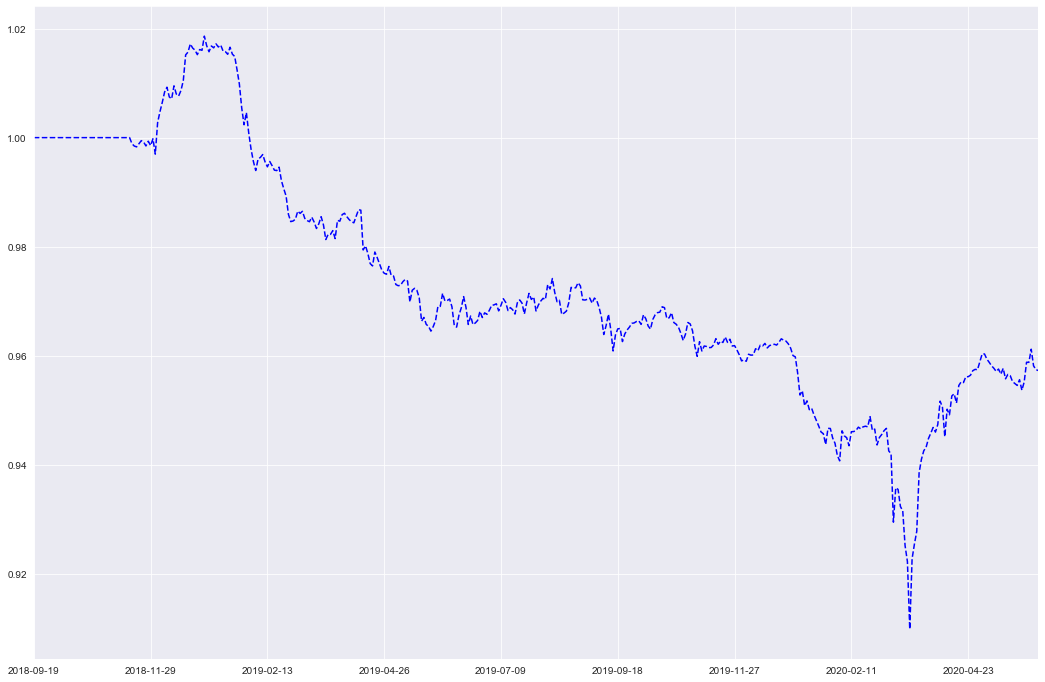

In [44]:
# PLOTS PORTFOLIO EQUITY CURVE
total_returns = 0
for equity_curve in all_cum_returns:
    total_returns += equity_curve 
total_returns = total_returns/len(all_cum_returns)
total_returns.plot(style = 'b--', figsize=(18,12))

total_returns_pct_chg = total_returns.pct_change()
total_returns_pct_chg

try:
    portfolio_sharpe_net = np.sqrt(252) * total_returns_pct_chg.mean() / total_returns_pct_chg.std()
except ZeroDivisionError:
    portfolio_sharpe_net = 0.0

end = total_returns.iloc[-1]
start = total_returns.iloc[0]
days = len(total_returns)
portfolio_cagr_net = ((end / start) ** (252/days))  - 1.0  

print(f'Portfolio of pairs performance:')
print(f'CAGR: {round(portfolio_cagr_net,4)}, Sharpe Ratio: {round(portfolio_sharpe_net,2)}')

The performance does not seem appealing... well this is well known strategy so cannot expect any 'magic'. However, at least we know that during last 6 months this strategy did not work.

It does not mean that the strategy will not work in the future. The market sentiment may change. During the last 2-3 years the market favours stocks with strong momentum and appealing growth of fundamentals. In this environment mean reversion strategies should be less profitable.

However, if you find a universe that generate good performance, you may like to check the current zScore for the selected pairs. 

The piece of code below checks the current (in real time) zScore for the selected pairs in part 2. 

We used beautiful soup library to fetch current price and then we append one row to existing dataframe. Finally, the script prints the zScore and hedge ratio for the pairs that have zScore above threshold in absolute terms.

### Part 4: Checking current zScore of cointegrated pairs

In [45]:
def currentPortfolio(df, sym1, sym2, roll_beta_window = 5, zscore_window = 25 ):
    
    y = df[sym1].iloc[-(2*(roll_beta_window+zscore_window)):]
    x = df[sym2].iloc[-(2*(roll_beta_window+zscore_window)):]

    # Scrapes the current (real-time) price of the asset from yahoo.com
    def getCurrentPrice(sym):
        source = requests.get(f'https://finance.yahoo.com/quote/{sym}')   # https://finance.yahoo.com/quote/VTI?p=VTI
        soup = BeautifulSoup(source.content, 'lxml')
        price = soup.select_one('.Trsdu\(0\.3s\)').text
        price = price = float(price.replace(',', ""))
#       time.sleep(1)
        return(price)
    
    # modify ticker depending on the historcital data source
    if sym1[-3:] == '.US' or sym2[-3:] == '.US'  :
        sym1 = (sym1.split('.')[0])
        sym2 = (sym2.split('.')[0])
    
    # selects a small part of the existing dataframe needed to compute current zScore 
    s4 = pd.Series([getCurrentPrice(sym1)], index=[date.today()])
    s5 = pd.Series([getCurrentPrice(sym2)], index=[date.today()])
    
    # appends the current price to existing dataframe
    y = y.append(s4) 
    x = x.append(s5) 

    # finds intersection between two series and make sure DataFrames are the same length
    intersect = y.index.intersection(x.index)
    y = y.loc[intersect]
    x = x.loc[intersect]

    # creates a dataframe using adj. close prices from both series
    dataframe = pd.DataFrame(index=y.index).dropna()
    dataframe['%s_close' % sym1.lower()] = y
    dataframe['%s_close' % sym2.lower()] = x   
    
    # calculates rolling hedge ratio and spread and zScore
    roll_fit = RollingOLS(y, x, window=roll_beta_window).fit()
    dataframe['hr'] = -roll_fit.params
    dataframe['test_spread'] = y + (x * dataframe.hr)
    meanSpread = dataframe['test_spread'].rolling(window=int(zscore_window)).mean()
    stdSpread = dataframe['test_spread'].rolling(window=int(zscore_window)).std()
    dataframe['zScore'] = (dataframe['test_spread']- meanSpread) / stdSpread

    return dataframe['zScore'][-1], dataframe['hr'][-1] 

# ------------------------------------------------#

#CHECKS CURRENT ZSCORE for ALL cointegrated pairs
zscore_treshold = 1.5
zscores_list = []
print(f'Getting data for the pairs with current Z-score above {zscore_treshold}....\n')
for c, pair in enumerate(coint_pairs):
    zscore_now, hedge_ratio_now = currentPortfolio(df[train_sample:], pair[0], pair[1], roll_beta_window = 5, zscore_window = 25)
    if abs(zscore_now) > abs(zscore_treshold):
        zscores_list.append((pair[0], pair[1], zscore_now, hedge_ratio_now))

if len(zscores_list) == 0:
    print('...')
    print(f'No pairs available to trade, i.e. no pairs with zscore > abs({zscore_treshold})')
else:    
    zscores_list_sorted = sorted(zscores_list, key=lambda x: abs(x[2]),reverse = True) 
    for c, pair in enumerate(zscores_list_sorted,1):
        if pair[2] < 0:
            print(f'{c}: Buy : 1.00 * |{pair[0]: <4}| Sell: {round(pair[3],5)}  * |{pair[1]: <4}| Z-Score: {round(pair[2],2)}')
        else:
            print(f'{c}: Sell: 1.00 * |{pair[0]: <4}| Buy:  {round(pair[3],5)}  * |{pair[1]: <4}| Z-Score:  {round(pair[2],2)}') 

Getting data for the pairs with current Z-score above 1.5....

1: Buy : 1.00 * |DIS.US| Sell: -2.42476  * |XOM.US| Z-Score: -2.04
2: Buy : 1.00 * |JNJ.US| Sell: -2.90738  * |XOM.US| Z-Score: -1.93
3: Buy : 1.00 * |MCD.US| Sell: -3.83153  * |XOM.US| Z-Score: -1.91
4: Buy : 1.00 * |KO.US| Sell: -0.95305  * |XOM.US| Z-Score: -1.85


Although, the strategy does not yield satisfactory results, we may like to check if there is a set of parameters that makes our strategy profitable.

In real trading, it is not good idea to optimise parameters, however we only learn how to code in Python....
The script below is not very fancy. It simply iterates through the range of parameters we set.

There are two scripts, the iterates through different hedge ratio window, the other iterates through different zScore window. You may easily modify this script to iterates also through different values of entryZscore and exitScore - possibly as a good programming task.

### Part 5: Parameters optimisation

In [46]:
# HELPER SCRIPT: Roll_beta_window optimisation

all_cagrs_and_sharpes = []
zscore_window = 20
entryZscore = 2.0
exitZscore = 0.5

# calculates portfolio Sharpe Ratio and CAGR  for each Roll_beta_window within the range
for x in range(10, 100, 5):
    all_cum_returns = []
    
    for pair in coint_pairs:
        cum_returns, CAGR, sharpe, num_days_in_the_market = backtest(df[train_sample:], pair[0],pair[1], strategy = 1, 
                                                                     roll_beta_window = x, zscore_window = zscore_window,
                                                                    entryZscore = entryZscore, exitZscore = exitZscore)
        all_cum_returns.append(cum_returns)
        
    total_returns = 0
    for equity_curve in all_cum_returns:
        total_returns += equity_curve 
    total_returns = total_returns/len(all_cum_returns)

    total_returns_pct_chg = total_returns.pct_change()

    try:
        portfolio_sharpe_net = np.sqrt(252) * total_returns_pct_chg.mean() / total_returns_pct_chg.std()
    except ZeroDivisionError:
        portfolio_sharpe_net = 0.0

    end = total_returns.iloc[-1]
    start = total_returns.iloc[0]
    days = len(total_returns)
    portfolio_cagr_net = ((end / start) ** (252/days))  - 1.0
    all_cagrs_and_sharpes.append((x, portfolio_cagr_net, portfolio_sharpe_net))
    
# sorts and prints ranked results based on Share Ratio
all_cagrs_and_sharpes = sorted(all_cagrs_and_sharpes, key=lambda x: x[2],reverse = True) 

for c, pair in enumerate(all_cagrs_and_sharpes, 1):
        print(f'{c}: Hedge ratio window: {pair[0]}, zScore window: {zscore_window}, CAGR: {round(pair[1],3)}, Sharpe Ratio: {round(pair[2],2)}')  

1: Hedge ratio window: 10, zScore window: 20, CAGR: -0.004, Sharpe Ratio: -0.15
2: Hedge ratio window: 25, zScore window: 20, CAGR: -0.018, Sharpe Ratio: -0.48
3: Hedge ratio window: 15, zScore window: 20, CAGR: -0.016, Sharpe Ratio: -0.56
4: Hedge ratio window: 30, zScore window: 20, CAGR: -0.024, Sharpe Ratio: -0.64
5: Hedge ratio window: 35, zScore window: 20, CAGR: -0.024, Sharpe Ratio: -0.67
6: Hedge ratio window: 90, zScore window: 20, CAGR: -0.029, Sharpe Ratio: -0.74
7: Hedge ratio window: 20, zScore window: 20, CAGR: -0.025, Sharpe Ratio: -0.76
8: Hedge ratio window: 95, zScore window: 20, CAGR: -0.03, Sharpe Ratio: -0.8
9: Hedge ratio window: 40, zScore window: 20, CAGR: -0.031, Sharpe Ratio: -0.85
10: Hedge ratio window: 85, zScore window: 20, CAGR: -0.037, Sharpe Ratio: -0.97
11: Hedge ratio window: 75, zScore window: 20, CAGR: -0.04, Sharpe Ratio: -1.03
12: Hedge ratio window: 80, zScore window: 20, CAGR: -0.039, Sharpe Ratio: -1.04
13: Hedge ratio window: 70, zScore windo

It turned out that none values of hedge ratio window yields positive Shape Ratio ... so let’s set hedge ratio at 10 (the best result) and iterate through different values of zScore.

In [47]:
# HELPER SCRIPT: Z-score_window optimisation

all_cagrs_and_sharpes_zscore_optim = []
total_returns_all = []
roll_beta_window = 10
entryZscore = 2.0
exitZscore = 0.5

# calculates portfolio Sharpe Ratio and CAGR  for each zScore window within the range
for x in range(10, 100, 5):
    all_cum_returns = []
    
    for pair in coint_pairs:
        cum_returns, CAGR, sharpe, num_days_in_the_market = backtest(df[train_sample:], pair[0],pair[1], strategy = 1, 
                                                                     roll_beta_window = roll_beta_window, zscore_window = x,
                                                                    entryZscore = entryZscore, exitZscore = exitZscore)
        all_cum_returns.append(cum_returns)

    total_returns = 0
    for equity_curve in all_cum_returns:
        total_returns += equity_curve    
    total_returns = total_returns/len(all_cum_returns)
    total_returns_all.append((x, total_returns))
    total_returns_pct_chg = total_returns.pct_change()

    try:
        portfolio_sharpe_net = np.sqrt(252) * total_returns_pct_chg.mean() / total_returns_pct_chg.std()
    except ZeroDivisionError:
        portfolio_sharpe_net = 0.0

    end = total_returns.iloc[-1]
    start = total_returns.iloc[0]
    days = len(total_returns)
    portfolio_cagr_net = ((end / start) ** (252/days))  - 1.0
    all_cagrs_and_sharpes_zscore_optim.append((x, portfolio_cagr_net, portfolio_sharpe_net))

# sorts and prints ranked results based on Share Ratio
all_cagrs_and_sharpes_zscore_optim = sorted(all_cagrs_and_sharpes_zscore_optim, key=lambda x: x[2],reverse = True) 
for c, pair in enumerate(all_cagrs_and_sharpes_zscore_optim, 1):
        print(f'{c}: Hedge ratio window: {roll_beta_window}, zScore window: {pair[0]}, CAGR: {round(pair[1],3)}, Sharpe Ratio: {round(pair[2],2)}')  

1: Hedge ratio window: 10, zScore window: 95, CAGR: 0.007, Sharpe Ratio: 0.22
2: Hedge ratio window: 10, zScore window: 90, CAGR: 0.006, Sharpe Ratio: 0.2
3: Hedge ratio window: 10, zScore window: 85, CAGR: 0.002, Sharpe Ratio: 0.08
4: Hedge ratio window: 10, zScore window: 15, CAGR: 0.001, Sharpe Ratio: 0.04
5: Hedge ratio window: 10, zScore window: 65, CAGR: -0.0, Sharpe Ratio: 0.01
6: Hedge ratio window: 10, zScore window: 80, CAGR: -0.003, Sharpe Ratio: -0.08
7: Hedge ratio window: 10, zScore window: 20, CAGR: -0.004, Sharpe Ratio: -0.15
8: Hedge ratio window: 10, zScore window: 70, CAGR: -0.008, Sharpe Ratio: -0.23
9: Hedge ratio window: 10, zScore window: 75, CAGR: -0.009, Sharpe Ratio: -0.25
10: Hedge ratio window: 10, zScore window: 30, CAGR: -0.008, Sharpe Ratio: -0.27
11: Hedge ratio window: 10, zScore window: 60, CAGR: -0.011, Sharpe Ratio: -0.34
12: Hedge ratio window: 10, zScore window: 35, CAGR: -0.01, Sharpe Ratio: -0.35
13: Hedge ratio window: 10, zScore window: 10, CAG

All right, finally we see profit... after optimisation we can state that possible successful set of parameters was : Hedge ratio window: 10 and zScore window: 95. This strategy generated 0.7% of annualised return and Sharpe of 0.22

Finally, lets plot the selected optimised strategy here below.

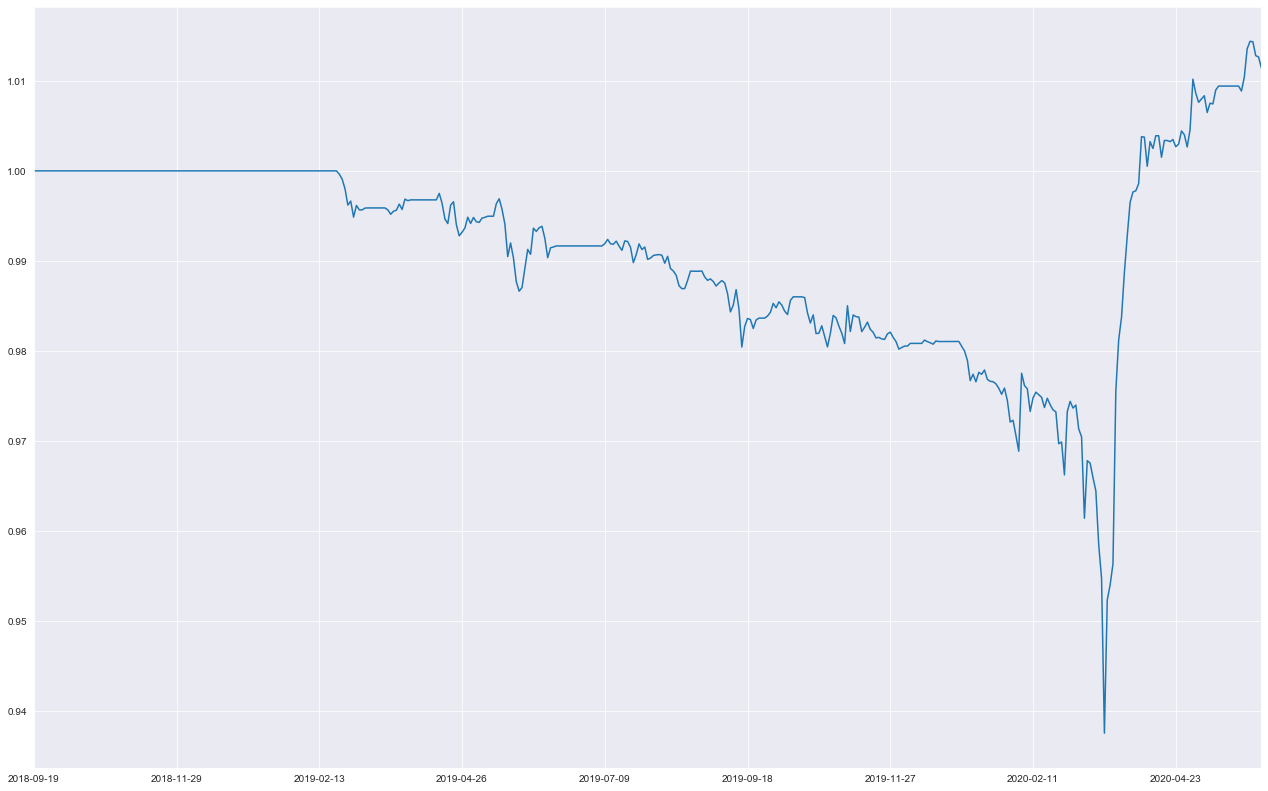

In [48]:
# PLOT EQUITY CURVE OF THE BEST MODEL : Hedge ratio window: 15, zScore window: 10, CAGR: 0.03, Sharpe Ratio: 1.08

# plots equity curve                                                             
total_returns_all[17][1].plot(figsize=(22,14),legend=False)

### CONCLUSION AND DISCLAIMER

This script presents fairly simple but complete and basic framework for Selection and Backtesting of a Portfolio of Pairs Based on Cointegration in Python. The results probably do not encourage to use this model into live trading, however the purpose of creating this notebook is purely educational. There are multiple ways how this basic framework may be extended into more unique and complex model.

If you have any questions, please send me email: p.arendarski...gmail.com...

DISCLAIMER:
This piece of code  is presented here is must be used solely for education perposes and can not be used under ciscumstances as a decision making tool in real trading.